In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Toggle between grayscale and RGB input
use_rgb = True
image_size = (64, 64)
input_channels = 3 if use_rgb else 1
input_size = image_size[0] * image_size[1] * input_channels

# Load images and labels
def load_images_from_folder(folder, label, use_rgb):
    images = []
    labels = []
    for filename in os.listdir(folder):
        flag = cv2.IMREAD_COLOR if use_rgb else cv2.IMREAD_GRAYSCALE
        img = cv2.imread(os.path.join(folder, filename), flag)
        if img is not None:
            img = cv2.resize(img, image_size)
            if use_rgb:
                img = img.transpose((2, 0, 1)).reshape(-1)  # HWC to CHW then flatten
            else:
                img = img.flatten()
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
            labels.append(label)
    return images, labels

pleasant_images, pleasant_labels = load_images_from_folder('train-images/train/pleasant', 1, use_rgb)
unpleasant_images, unpleasant_labels = load_images_from_folder('train-images/train/unpleasant', 0, use_rgb)

X = np.array(pleasant_images + unpleasant_images, dtype=np.float32)
y = np.array(pleasant_labels + unpleasant_labels, dtype=np.int64)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Define MLP model class for each activation function
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn):
        super(MLP, self).__init__()
        layers = []
        in_features = input_size
        for hidden_units in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_units))
            if activation_fn == 'relu':
                layers.append(nn.ReLU())
            elif activation_fn == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation_fn == 'tanh':
                layers.append(nn.Tanh())
            elif activation_fn == 'prelu':
                layers.append(nn.PReLU())
            in_features = hidden_units
        layers.append(nn.Linear(in_features, 2))  # binary classification
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

Epoch 1/20, Loss: 0.6357
Epoch 2/20, Loss: 0.4610
Epoch 3/20, Loss: 0.5398
Epoch 4/20, Loss: 0.3618
Epoch 5/20, Loss: 0.4715
Epoch 6/20, Loss: 0.3496
Epoch 7/20, Loss: 0.2308
Epoch 8/20, Loss: 0.4427
Epoch 9/20, Loss: 0.3152
Epoch 10/20, Loss: 0.3227
Epoch 11/20, Loss: 0.3579
Epoch 12/20, Loss: 0.2715
Epoch 13/20, Loss: 0.2217
Epoch 14/20, Loss: 0.2822
Epoch 15/20, Loss: 0.2699
Epoch 16/20, Loss: 0.2375
Epoch 17/20, Loss: 0.2432
Epoch 18/20, Loss: 0.3162
Epoch 19/20, Loss: 0.0859
Epoch 20/20, Loss: 0.3048
Accuracy: 0.8581504702194357
Precision: 0.9357638888888888
Recall: 0.7891654465592972
F1 Score: 0.8562351072279587
Confusion Matrix:
 [[556  37]
 [144 539]]


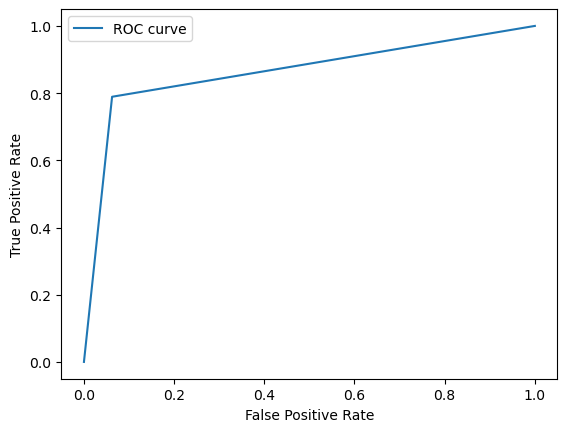

Submission file saved with MLP predictions.


In [2]:
# Hyperparameters
hidden_layers = [512, 256]
# choose between 'relu', 'sigmoid', 'tanh', 'prelu'
activation = 'prelu'
# choose between 'adam', 'sgd'
optimizer_choice = 'adam'

model = MLP(input_size=input_size, hidden_layers=hidden_layers, activation_fn=activation)
criterion = nn.CrossEntropyLoss()

if optimizer_choice == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
elif optimizer_choice == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluation
model.eval()
y_preds, y_trues = [], []
with torch.no_grad():
    for batch_x, batch_y in val_loader:
        outputs = model(batch_x)
        _, preds = torch.max(outputs, 1)
        y_preds.extend(preds.tolist())
        y_trues.extend(batch_y.tolist())

print("Accuracy:", accuracy_score(y_trues, y_preds))
print("Precision:", precision_score(y_trues, y_preds))
print("Recall:", recall_score(y_trues, y_preds))
print("F1 Score:", f1_score(y_trues, y_preds))
print("Confusion Matrix:\n", confusion_matrix(y_trues, y_preds))

fpr, tpr, _ = roc_curve(y_trues, np.array(y_preds))
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Predict test set
test_df = pd.read_csv('Test-IDs.csv')
submission = []

for _, row in test_df.iterrows():
    img_path = os.path.join('TEST_images/TEST_images', row['Filename'])
    flag = cv2.IMREAD_COLOR if use_rgb else cv2.IMREAD_GRAYSCALE
    img = cv2.imread(img_path, flag)
    if img is not None:
        img = cv2.resize(img, image_size)
        if use_rgb:
            img = img.transpose((2, 0, 1)).reshape(-1)
        else:
            img = img.flatten()
        img = img / 255.0
        img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        output = model(img_tensor)
        _, pred = torch.max(output, 1)
        submission.append({'ID': row['ID'], 'LABEL': pred.item()})

submission_df = pd.DataFrame(submission, columns=['ID', 'LABEL'])
submission_df.to_csv('submission.csv', index=False)
print("Submission file saved with MLP predictions.")